In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

### Parameters

In [2]:
MASSES = [1, 1, 1]
PARTICLES = len(MASSES)
T = 50
T_PLOT = 100
LEARNING_STEPS = 200

FOURIER_TERMS = 15

W = ( A_c, A_s, B_c, B_s, phi )

In [3]:
def position (W, i, t):
    
    a, b, c, d, phi = W
    
    pos_x, pos_y = 0, 0
    
    for k in range(FOURIER_TERMS + 1):
        
        pos_x += a[k] * np.cos( k * ( t + phi[i] ) ) + b[k] * np.sin( k * ( t + phi[i] ) )
        pos_y += c[k] * np.cos( k * ( t + phi[i] ) ) + d[k] * np.sin( k * ( t + phi[i] ) )
        
    return np.array([pos_x, pos_y])

def speed(W, i, t):
    
    a, b, c, d, phi = W
    
    vel_x, vel_y = 0, 0
    
    for k in range(FOURIER_TERMS + 1):
        
        vel_x += k * ( - a[k] * np.sin( k * ( t + phi[i] ) ) + b[k] * np.cos( k * ( t + phi[i] ) ) )
        vel_y += k * ( - c[k] * np.sin( k * ( t + phi[i] ) ) + d[k] * np.cos( k * ( t + phi[i] ) ) )
        
    return np.array([vel_x, vel_y])
        
def action (W):
    
    S = 0
    
    for t in range(T):
        
        time = 2 * t * np.pi / T
        
        for i in range(PARTICLES):
            
            S += ( MASSES[i] / 2 ) * np.linalg.norm( speed(W, i, time) ) ** 2
            
            for j in range(i + 1, PARTICLES):
                
                S += MASSES[i] * MASSES[j] / ( np.linalg.norm( position(W, i, time) 
                                                             - position(W, j, time) ) )
        
    return S * ( 2 * np.pi / T )
    
def ploteo_trayectorias (W, show=True):
    
    for i in range(PARTICLES):
    
        pos_x, pos_y = [], []
    
        for t in range(T_PLOT):
            
            pos = position(W, i , 2 * t * np.pi / T_PLOT)
            pos_x.append( pos[0] )
            pos_y.append( pos[1] )
            
                        
        plt.scatter(pos[0], pos[1], c = 'black', s = 50 * MASSES[i] )
        
        plt.plot(pos_x, pos_y, "-", c="black", lw = 1)
        
    plt.axis("equal")
    plt.axis('off')
    if show:
        plt.show()
    
    
def grad (W, actualize_bias = False):
    
    a, b, c, d, phi = W

    grad_a = np.zeros( ( FOURIER_TERMS + 1 ) )
    grad_b = np.zeros( ( FOURIER_TERMS + 1 ) )
    grad_c = np.zeros( ( FOURIER_TERMS + 1 ) )
    grad_d = np.zeros( ( FOURIER_TERMS + 1 ) )
    
    for t in range(T):
        
        time = 2 * t * np.pi / T
        
        for i in range( PARTICLES ):
            
            pos_i = position(W, i, time )
            vel_i = speed(W, i, time )
            
            for k in range( FOURIER_TERMS + 1 ):
                
                t_ki = k * ( time + phi[i] )

                if k == 0 and not actualize_bias:    
                    continue
                                
                grad_a [k] += - MASSES[i] * vel_i[0] * np.sin( t_ki ) * k
                grad_b [k] += + MASSES[i] * vel_i[0] * np.cos( t_ki ) * k
                grad_c [k] += - MASSES[i] * vel_i[1] * np.sin( t_ki ) * k
                grad_d [k] += + MASSES[i] * vel_i[1] * np.cos( t_ki ) * k

                for j in range( i + 1, PARTICLES ):
                    
                    t_kj = k * ( time + phi[j] )
                    
                    pos_j = position(W, j, time)
                    vel_j = speed(W, j, time)
                    
                    grad_a [k] += - MASSES[i] * MASSES[j]   \
                                        / ( np.linalg.norm( pos_i - pos_j ) ** 3 ) \
                                        * ( pos_i[0] - pos_j[0] ) \
                                        * ( np.cos( t_ki ) - np.cos( t_kj ) )
                    grad_b [k] += - MASSES[i] * MASSES[j]   \
                                        / ( np.linalg.norm( pos_i - pos_j ) ** 3 ) \
                                        * ( pos_i[0] - pos_j[0] ) \
                                        * ( np.sin( t_ki ) - np.sin( t_kj ) )
                    grad_c [k] += - MASSES[i] * MASSES[j]   \
                                        / ( np.linalg.norm( pos_i - pos_j ) ** 3 ) \
                                        * ( pos_i[1] - pos_j[1] ) \
                                        * ( np.cos( t_ki ) - np.cos( t_kj ) )
                    grad_d [k] += - MASSES[i] * MASSES[j]   \
                                        / ( np.linalg.norm( pos_i - pos_j ) ** 3 ) \
                                        * ( pos_i[1] - pos_j[1] ) \
                                        * ( np.sin( t_ki ) - np.sin( t_kj ) )
                                
                    
    grad_phi = np.zeros( ( PARTICLES ) )

    for t in range(T):
        
        time = 2 * t * np.pi / T
        
        for i in range( PARTICLES ):
        
            sum1, sum2 = 0, 0 
            
            pos_i = position(W, i, time )
            vel_i = speed(W, i, time )

            for k in range( FOURIER_TERMS + 1 ):
                
                t_ki = k * ( time + phi[i] )

                sum1 += k * k * ( a[k] * np.cos( t_ki ) + b[k] * np.sin( t_ki ) )
                sum2 += k * k * ( c[k] * np.cos( t_ki ) + d[k] * np.sin( t_ki ) )

            grad_phi[i] += - MASSES[i] * vel_i[0] * sum1
            grad_phi[i] += - MASSES[i] * vel_i[1] * sum2
            
            for j in range( PARTICLES ):
                
                if j == i:
                    continue
                    
                t_kj = k * ( time + phi[j] )
                    
                pos_j = position(W, j, time )
                vel_j = speed(W, j, time )
                    
                grad_phi[i] += - MASSES[i] * MASSES[j]                       \
                               / ( np.linalg.norm( pos_i - pos_j ) ** 3 )    \
                               * ( ( pos_i[0] - pos_j[0] ) * ( vel_i[0] - vel_j[0] ) +          \
                                   ( pos_i[1] - pos_j[1] ) * ( vel_i[1] - vel_j[0] ) )
                
    
    grad_a = ( (2 * np.pi / T ) ** 2 ) * grad_a
    grad_b = ( (2 * np.pi / T ) ** 2 ) * grad_b
    grad_c = ( (2 * np.pi / T ) ** 2 ) * grad_c
    grad_d = ( (2 * np.pi / T ) ** 2 ) * grad_d
    grad_phi = ( 2 * np.pi / T ) * grad_phi
    
    return np.array([grad_a, grad_b, grad_c, grad_d, grad_phi])

def initialization( PARTICLES, FOURIER_TERMS, mode = "RANDOM", density = 1.0, decay = 0.0 ):
    
      
    a_0 = np.random.normal( size = ( FOURIER_TERMS + 1 ) ) 
    b_0 = np.random.normal( size = ( FOURIER_TERMS + 1 ) ) 
    c_0 = np.random.normal( size = ( FOURIER_TERMS + 1 ) ) 
    d_0 = np.random.normal( size = ( FOURIER_TERMS + 1 ) ) 

    if density < 1.0:
        
        a_0[ np.random.random( a_0.shape ) > density ] = 0
        b_0[ np.random.random( b_0.shape ) > density ] = 0
        c_0[ np.random.random( c_0.shape ) > density ] = 0
        d_0[ np.random.random( d_0.shape ) > density ] = 0

    if decay > 0 :
        
        factor = np.array( [0] + [ k ** ( - decay)  for k in range( 1,  FOURIER_TERMS + 1 ) ] )
        a_0 = a_0 * factor
        b_0 = b_0 * factor
        c_0 = c_0 * factor
        d_0 = d_0 * factor
    
    a_0[0] = 0
    b_0[0] = 0
    c_0[0] = 0
    d_0[0] = 0
    
    phi_0 = np.linspace(0, 2 * np.pi, PARTICLES+1)[0:-1]
        
    return np.array([ a_0, b_0, c_0, d_0, phi_0 ])

## Gradient descent

#### Normal gradient descent

In [4]:
def gradient_descent_0 (LEARNING_RATE, LEARNING_STEPS, grad_stop=1e-4, ploteo=False):
    
    W_0 = initialization( PARTICLES, FOURIER_TERMS, density=0.5, decay = 1)
    Ws = [W_0]
    
    for step in range(LEARNING_STEPS):

        grad_W = grad(Ws[-1])
        
        if np.sum( [ np.linalg.norm(a) for a in grad_W ] ) < grad_stop:
            break
        
        Ws.append( Ws[-1] - LEARNING_RATE * grad_W )
        
        print("Step No", step , " --->", action(Ws[-1]))

    if ploteo == True:
        
        S_improvement = [ action(w) for w in Ws ]
        plt.close()
        plt.semilogy( range(len(S_improvement)), S_improvement )
        plt.xlabel("step")
        plt.ylabel("Action")
        plt.show()
        #plt.savefig( "6-" + str(ii) + "_entrenamiento.png", format="png", dpi=300 )

    return Ws[-1]

#### Gradient descent with Armijo's Rule

In [5]:
def armijo (LEARNING_STEPS, init="RANDOM", W0 = 1, eps=0.2, eta=2):
    
    alpha = 1
    
    if init == "RANDOM":
        W_0 = initialization( PARTICLES, FOURIER_TERMS, density=0.3, decay = 1)
    if init == "GIVEN":
        W_0 = W0
    
    Ws = [W_0]
    
    for step in range(LEARNING_STEPS):

        grad_W = grad(Ws[-1])
                
        delta = 1e-4
        Delta_W = (action(Ws[-1] - delta * grad_W) - action(Ws[-1]) ) / delta
        norm_grad_W = np.abs(Delta_W)         
            
        if step > 5 and np.abs( action(Ws[-1]) - action(Ws[-5]) ) < 1e-10:
            break

        if action(Ws[-1] - alpha * grad_W ) <= action(Ws[-1]) - eps * alpha * norm_grad_W:
            while action(Ws[-1] - alpha * grad_W ) <= action(Ws[-1]) - eps * alpha * norm_grad_W:
                alpha = alpha * eta
            alpha = alpha / eta
        else:
            while action(Ws[-1] - alpha * grad_W ) >  action(Ws[-1]) - eps * alpha * norm_grad_W:
                alpha = alpha / eta
        
        Ws.append( Ws[-1] - alpha * grad_W )
        
        print("Step No", step , " --->", action(Ws[-1]))
        
    return Ws[-1]

#### Simulated Annealing

In [6]:
def simulated_annealing (LEARNING_STEPS, T0=1):
    
    W = initialization( PARTICLES, FOURIER_TERMS, density=0.3, decay = 1)

    for k in range(LEARNING_STEPS):
        
        temp = np.divide( 100 * (LEARNING_STEPS - k), LEARNING_STEPS )
        
        delta_W = 0.01 * initialization( PARTICLES, FOURIER_TERMS, density=1, decay = 0)
        W_new = W + delta_W
        
        if action(W_new) < action(W):
            W = W_new
        else:
            if np.exp( - ( action(W_new) - action(W) ) / temp ) > np.random.uniform():
                W = W_new
                
        print("Step No", k, " --->", action(W))
                
    return W

#### Simulated Annealing + Armijo

In [7]:
def mixture(LEARNING_STEPS_INIT, LEARNING_STEPS_ARMIJO):
    
    W0 = simulated_annealing(LEARNING_STEPS_INIT)
    W  = armijo(LEARNING_STEPS_ARMIJO, init="GIVEN", W0=W0)
    
    return W

# Experiments

---------------------
Step No 0  ---> 133.08445728210546
Step No 1  ---> 137.33673085243805
Step No 2  ---> 134.01418939981158
Step No 3  ---> 143.66355243205234
Step No 4  ---> 149.4186308505826
Step No 5  ---> 155.04781863686907
Step No 6  ---> 156.13086196223924
Step No 7  ---> 160.34943246197238
Step No 8  ---> 164.28421281036455
Step No 9  ---> 173.8827430510835
Step No 10  ---> 179.4362902349775
Step No 11  ---> 181.53201356538386
Step No 12  ---> 189.417763115701
Step No 13  ---> 197.7456356357596
Step No 14  ---> 206.04117775239106
Step No 15  ---> 200.75752485074136
Step No 16  ---> 204.25929161051585
Step No 17  ---> 204.25929161051585
Step No 18  ---> 213.10419052392587
Step No 19  ---> 214.53291776866936
Step No 20  ---> 219.86841461693885
Step No 21  ---> 221.38810186135268
Step No 22  ---> 220.03960902561428
Step No 23  ---> 226.20094516595225
Step No 24  ---> 224.6957273042945
Step No 25  ---> 224.6957273042945
Step No 26  ---> 223.2048981779482
Step No 27  ---> 211.6916

Step No 181  ---> 19.604328185225576
Step No 182  ---> 19.6043281848501
Step No 183  ---> 19.60432818449548
Step No 184  ---> 19.604328184158646
Step No 185  ---> 19.6043281838378
Step No 186  ---> 19.604328183531702
Step No 187  ---> 19.604328183239776
Step No 188  ---> 19.604328182961765
Step No 189  ---> 19.60432818269769
Step No 190  ---> 19.604328182447908
Step No 191  ---> 19.604328182042018
Step No 192  ---> 19.604328177104186
Step No 193  ---> 19.604328175100004
Step No 194  ---> 19.604328174958674
Step No 195  ---> 19.604328174730636
Step No 196  ---> 19.604328174100264
Step No 197  ---> 19.604328173652107
Step No 198  ---> 19.60432817354648
Step No 199  ---> 19.604328173458725
Step No 200  ---> 19.604328173221177
Step No 201  ---> 19.604328172893855
Step No 202  ---> 19.604328172861983
Step No 203  ---> 19.60432817283508
Step No 204  ---> 19.60432817281052
Step No 205  ---> 19.60432817278772
Step No 206  ---> 19.604328172766284


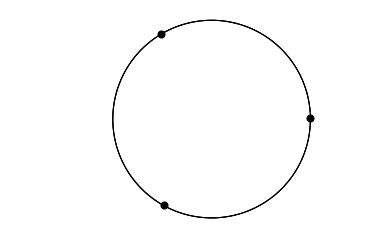

---------------------
Step No 0  ---> 161.7384930850819
Step No 1  ---> 185.81817341354187
Step No 2  ---> 174.0154130943354
Step No 3  ---> 174.0154130943354
Step No 4  ---> 181.71874290353523
Step No 5  ---> 179.19287946757683
Step No 6  ---> 181.4019038686973
Step No 7  ---> 182.276242292241
Step No 8  ---> 182.03386966011163
Step No 9  ---> 186.44362169446507
Step No 10  ---> 183.4340965490534
Step No 11  ---> 187.5427508615121
Step No 12  ---> 187.5427508615121
Step No 13  ---> 196.96743998305718
Step No 14  ---> 187.76079082048128
Step No 15  ---> 187.76079082048128
Step No 16  ---> 188.11618586438064
Step No 17  ---> 189.68935879656107
Step No 18  ---> 189.68935879656107
Step No 19  ---> 217.31545137307614
Step No 20  ---> 207.63963861774766
Step No 21  ---> 210.4713864616199
Step No 22  ---> 211.74448788380764
Step No 23  ---> 213.3997405296047
Step No 24  ---> 221.0601026945823
Step No 25  ---> 219.4823226836138
Step No 26  ---> 220.18124398745383
Step No 27  ---> 221.25136172

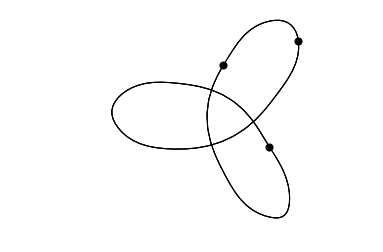

---------------------
Step No 0  ---> 99.50478503432359
Step No 1  ---> 101.40379996246944
Step No 2  ---> 103.97212048944631
Step No 3  ---> 105.94551358893983
Step No 4  ---> 107.71901012115636
Step No 5  ---> 108.94352090794995
Step No 6  ---> 113.17089290575316
Step No 7  ---> 132.72373543883893
Step No 8  ---> 125.92181295834513
Step No 9  ---> 125.92181295834513
Step No 10  ---> 127.9992912207335
Step No 11  ---> 124.36120864587816
Step No 12  ---> 129.09339052696401
Step No 13  ---> 143.97596387382166
Step No 14  ---> 145.62842124376803
Step No 15  ---> 143.35527137707302
Step No 16  ---> 143.7164687355961
Step No 17  ---> 147.6725273398151
Step No 18  ---> 155.05759884351647
Step No 19  ---> 155.8808617388476
Step No 20  ---> 158.10280221178414
Step No 21  ---> 163.9363079514544
Step No 22  ---> 158.79978801141436
Step No 23  ---> 156.6668406284329
Step No 24  ---> 169.32087067516065
Step No 25  ---> 170.0624029754546
Step No 26  ---> 170.0624029754546
Step No 27  ---> 185.6636

Step No 178  ---> 19.60432817264491
Step No 179  ---> 19.604328172628215
Step No 180  ---> 19.60432817261276


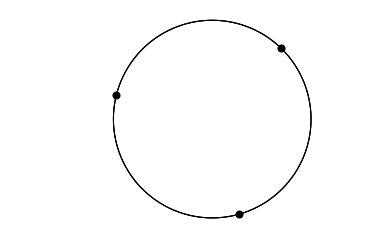

---------------------
Step No 0  ---> 98.54810840665021
Step No 1  ---> 100.7244180887206
Step No 2  ---> 110.8783897838451
Step No 3  ---> 118.6407741817297
Step No 4  ---> 111.40200388726683
Step No 5  ---> 111.40200388726683
Step No 6  ---> 118.58202720914656
Step No 7  ---> 116.40001244770312
Step No 8  ---> 120.15035884032712
Step No 9  ---> 117.44869821126686
Step No 10  ---> 108.28903417066822
Step No 11  ---> 116.60901649434987
Step No 12  ---> 122.73073322026751
Step No 13  ---> 116.72553452277583
Step No 14  ---> 112.38471006840844
Step No 15  ---> 123.17753878663613
Step No 16  ---> 128.7101014396663
Step No 17  ---> 135.2452352700171
Step No 18  ---> 138.977846341167
Step No 19  ---> 149.03594582603014
Step No 20  ---> 146.2312111156758
Step No 21  ---> 147.9863509442252
Step No 22  ---> 155.31046782554
Step No 23  ---> 156.62793405650976
Step No 24  ---> 151.75375721643047
Step No 25  ---> 155.5009114264602
Step No 26  ---> 155.17388584554507
Step No 27  ---> 163.000873798

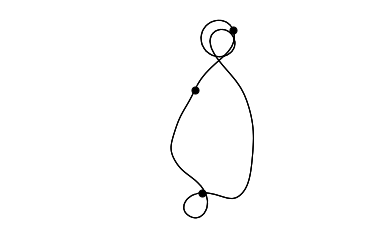

---------------------
Step No 0  ---> 189.16072933093807
Step No 1  ---> 197.39559651442787
Step No 2  ---> 190.5165107621782
Step No 3  ---> 197.59255445381075
Step No 4  ---> 198.83673962204833
Step No 5  ---> 204.76864578343148
Step No 6  ---> 208.91343129686337
Step No 7  ---> 206.82294085133114
Step No 8  ---> 207.49028996212974
Step No 9  ---> 210.78910624267942
Step No 10  ---> 210.51701802585595
Step No 11  ---> 210.51060943135246
Step No 12  ---> 215.9455906271371
Step No 13  ---> 222.9576413600699
Step No 14  ---> 229.64808071154593
Step No 15  ---> 228.0598897023879
Step No 16  ---> 225.82941540908874
Step No 17  ---> 223.23523489489455
Step No 18  ---> 226.50198778977864
Step No 19  ---> 230.50585343484047
Step No 20  ---> 225.95889732732743
Step No 21  ---> 227.09778057506583
Step No 22  ---> 228.1870857562985
Step No 23  ---> 235.321556080075
Step No 24  ---> 231.00651699713498
Step No 25  ---> 243.68548136982568
Step No 26  ---> 241.45234973815562
Step No 27  ---> 245.78

Step No 179  ---> 19.60432817268531
Step No 180  ---> 19.60432817260772
Step No 181  ---> 19.604328172544
Step No 182  ---> 19.604328172510044
Step No 183  ---> 19.604328172490938
Step No 184  ---> 19.60432817247488
Step No 185  ---> 19.604328172460754


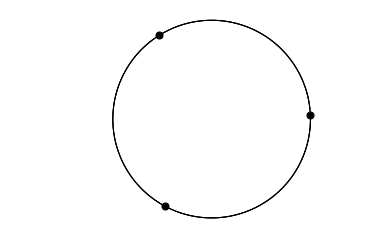

---------------------
Step No 0  ---> 100.55251317678886
Step No 1  ---> 107.12474944551579
Step No 2  ---> 112.63491865418193
Step No 3  ---> 108.90621913155303
Step No 4  ---> 112.55264732690806
Step No 5  ---> 114.44046971061535
Step No 6  ---> 109.8342614904966
Step No 7  ---> 105.11838806689755
Step No 8  ---> 98.1864856345805
Step No 9  ---> 101.26525712903529
Step No 10  ---> 106.45572385889089
Step No 11  ---> 107.63700818102147
Step No 12  ---> 103.85156895661304
Step No 13  ---> 106.33534448869835
Step No 14  ---> 117.53559070243912
Step No 15  ---> 119.33266459734455
Step No 16  ---> 123.4136666614263
Step No 17  ---> 120.45874720130983
Step No 18  ---> 124.27896510267472
Step No 19  ---> 130.32419862514985
Step No 20  ---> 135.31675989686903
Step No 21  ---> 132.0538377306844
Step No 22  ---> 135.00823779065195
Step No 23  ---> 135.1854514179953
Step No 24  ---> 134.49114443621693
Step No 25  ---> 136.7113745915601
Step No 26  ---> 143.67840496144473
Step No 27  ---> 143.67

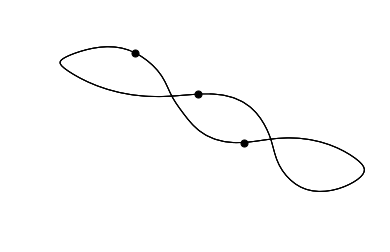

---------------------
Step No 0  ---> 92.27063070255474
Step No 1  ---> 95.46469823324581
Step No 2  ---> 96.57284629817076
Step No 3  ---> 101.60661132264038
Step No 4  ---> 100.57010476757888
Step No 5  ---> 100.57010476757888
Step No 6  ---> 100.30301943915521
Step No 7  ---> 104.40086726351483
Step No 8  ---> 102.74914327912774
Step No 9  ---> 105.02200428696602
Step No 10  ---> 110.03922613472464
Step No 11  ---> 110.23568523877076
Step No 12  ---> 113.19015818367816
Step No 13  ---> 120.49782698848105
Step No 14  ---> 139.00773000067773
Step No 15  ---> 138.1490254365271
Step No 16  ---> 132.80211539086446
Step No 17  ---> 131.561196941712
Step No 18  ---> 122.64064981713898
Step No 19  ---> 122.64064981713898
Step No 20  ---> 124.63330036303111
Step No 21  ---> 126.32599564121045
Step No 22  ---> 126.13639733835836
Step No 23  ---> 129.91291757072167
Step No 24  ---> 131.9929910654599
Step No 25  ---> 133.79952819728246
Step No 26  ---> 139.4874069533982
Step No 27  ---> 139.436

Step No 184  ---> 38.69302103537432
Step No 185  ---> 38.69302103527441
Step No 186  ---> 38.693021035113865
Step No 187  ---> 38.69302103406141
Step No 188  ---> 38.69302103342256
Step No 189  ---> 38.693021033327774
Step No 190  ---> 38.69302103327873
Step No 191  ---> 38.69302103320244
Step No 192  ---> 38.69302103268286
Step No 193  ---> 38.69302103238172
Step No 194  ---> 38.693021032350224
Step No 195  ---> 38.69302103224531
Step No 196  ---> 38.693021032184646
Step No 197  ---> 38.693021032033066
Step No 198  ---> 38.69302103201243
Step No 199  ---> 38.69302103194552
Step No 200  ---> 38.693021031912686
Step No 201  ---> 38.69302103187033
Step No 202  ---> 38.69302103184281
Step No 203  ---> 38.69302103181291
Step No 204  ---> 38.69302103179548
Step No 205  ---> 38.693021031783104


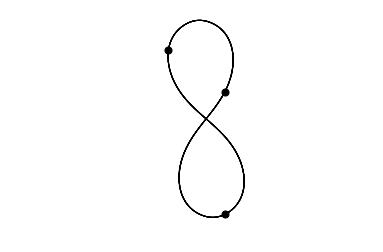

---------------------
Step No 0  ---> 154.79765048717195
Step No 1  ---> 148.80797858295907
Step No 2  ---> 150.7939719782233
Step No 3  ---> 157.2269224685281
Step No 4  ---> 150.85628943369096
Step No 5  ---> 148.7444716356809
Step No 6  ---> 148.7444716356809
Step No 7  ---> 152.73053127384821
Step No 8  ---> 158.92052246458812
Step No 9  ---> 155.71713796253493
Step No 10  ---> 156.56239306581787
Step No 11  ---> 161.26379742668132
Step No 12  ---> 173.06481046831752
Step No 13  ---> 168.05189967111707
Step No 14  ---> 171.8870611702
Step No 15  ---> 171.8870611702
Step No 16  ---> 174.66591305934725
Step No 17  ---> 181.63021943173536
Step No 18  ---> 175.30114599549177
Step No 19  ---> 169.83970229565492
Step No 20  ---> 174.56303008439414
Step No 21  ---> 174.35184235013608
Step No 22  ---> 170.9423885693292
Step No 23  ---> 170.9423885693292
Step No 24  ---> 168.75731467386672
Step No 25  ---> 179.6536147271966
Step No 26  ---> 171.6581280844793
Step No 27  ---> 162.54183415881

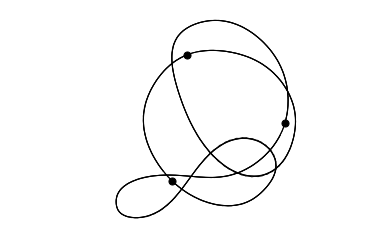

---------------------
Step No 0  ---> 121.43968761921295
Step No 1  ---> 125.29805551794131
Step No 2  ---> 132.2120040715971
Step No 3  ---> 126.70485700037975
Step No 4  ---> 115.95607524432955
Step No 5  ---> 113.21670061295364
Step No 6  ---> 110.91983554227038
Step No 7  ---> 115.55452002286076
Step No 8  ---> 125.54783471360152
Step No 9  ---> 128.6519728147087
Step No 10  ---> 134.25053950375244
Step No 11  ---> 127.9940243845135
Step No 12  ---> 138.77320327058095
Step No 13  ---> 145.7110300379187
Step No 14  ---> 148.01869127205276
Step No 15  ---> 159.62608923853915
Step No 16  ---> 170.77007580852947
Step No 17  ---> 170.62753580806103
Step No 18  ---> 179.4230534089075
Step No 19  ---> 177.34305634058356
Step No 20  ---> 181.0210288052935
Step No 21  ---> 183.45715430585906
Step No 22  ---> 180.80293602643442
Step No 23  ---> 190.179733474981
Step No 24  ---> 190.179733474981
Step No 25  ---> 200.20073929102048
Step No 26  ---> 199.82865160611212
Step No 27  ---> 199.82865

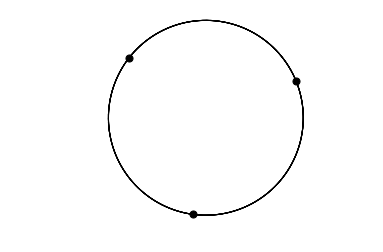

---------------------
Step No 0  ---> 80.6823435767795
Step No 1  ---> 81.81095890509837
Step No 2  ---> 84.9258632769739
Step No 3  ---> 88.78451013759337
Step No 4  ---> 91.46179907370954
Step No 5  ---> 90.71473551758842
Step No 6  ---> 95.26253534323438
Step No 7  ---> 96.24926243660839
Step No 8  ---> 100.88124864357604
Step No 9  ---> 103.8267867189259
Step No 10  ---> 109.22817344744368
Step No 11  ---> 112.2793761770462
Step No 12  ---> 113.35859815828955
Step No 13  ---> 116.7166597801484
Step No 14  ---> 124.09467367776982
Step No 15  ---> 118.35698557321714
Step No 16  ---> 117.10246362780327
Step No 17  ---> 120.04613614318217
Step No 18  ---> 119.59366134672108
Step No 19  ---> 126.05474611185458
Step No 20  ---> 127.07087210025439
Step No 21  ---> 124.29010764239709
Step No 22  ---> 124.29010764239709
Step No 23  ---> 130.14238757109814
Step No 24  ---> 126.4416263024011
Step No 25  ---> 134.68789185697716
Step No 26  ---> 133.68631820770125
Step No 27  ---> 139.449549304

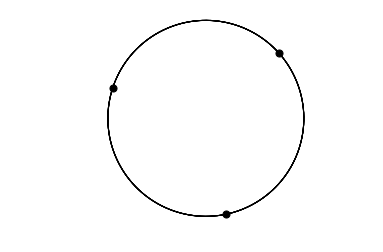

---------------------
Step No 0  ---> 163.86376114250552
Step No 1  ---> 186.91683076167078
Step No 2  ---> 169.39615655684472
Step No 3  ---> 169.51574943968816
Step No 4  ---> 174.6417422732383
Step No 5  ---> 171.2458939269045
Step No 6  ---> 171.2458939269045
Step No 7  ---> 165.53495621523555
Step No 8  ---> 164.73607856896743
Step No 9  ---> 158.6734874750466
Step No 10  ---> 159.4468548183489
Step No 11  ---> 160.42943959216504
Step No 12  ---> 163.79268213965798
Step No 13  ---> 158.9575261023868
Step No 14  ---> 156.9157484698913
Step No 15  ---> 153.1263835617672
Step No 16  ---> 155.32339740000165
Step No 17  ---> 166.12033030183588
Step No 18  ---> 172.9197209759062
Step No 19  ---> 182.71791640112693
Step No 20  ---> 182.71791640112693
Step No 21  ---> 176.8164610683188
Step No 22  ---> 177.728059141276
Step No 23  ---> 180.26074715378624
Step No 24  ---> 174.90229043189862
Step No 25  ---> 170.9150910405128
Step No 26  ---> 173.78924983144617
Step No 27  ---> 176.99336712

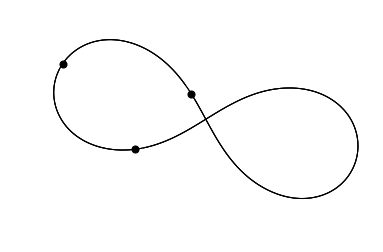

---------------------
Step No 0  ---> 104.83636290052534
Step No 1  ---> 106.39829179821753
Step No 2  ---> 107.02471802531092
Step No 3  ---> 100.66080481258095
Step No 4  ---> 101.27903124415742
Step No 5  ---> 109.36794061134472
Step No 6  ---> 111.03073151608238
Step No 7  ---> 108.84557688302715
Step No 8  ---> 112.6361258616245
Step No 9  ---> 125.11450335076759
Step No 10  ---> 119.1211172267496
Step No 11  ---> 117.9975217954658
Step No 12  ---> 128.46077402608503
Step No 13  ---> 129.90594252550008
Step No 14  ---> 167.89488837498922
Step No 15  ---> 141.18371164862214
Step No 16  ---> 133.01129185276432
Step No 17  ---> 125.62429797415089
Step No 18  ---> 122.89346050853791
Step No 19  ---> 132.3737656868932
Step No 20  ---> 136.81254515869813
Step No 21  ---> 138.4093309398454
Step No 22  ---> 152.17913898011187
Step No 23  ---> 150.20124635719006
Step No 24  ---> 148.44985942304592
Step No 25  ---> 151.012891858293
Step No 26  ---> 159.95483621864383
Step No 27  ---> 164.94

Step No 184  ---> 31.119931685918164
Step No 185  ---> 31.11993167423418
Step No 186  ---> 31.119931656221517
Step No 187  ---> 31.1199314870128
Step No 188  ---> 31.11993135909389
Step No 189  ---> 31.119931342018084
Step No 190  ---> 31.11993132257215
Step No 191  ---> 31.119931301955265
Step No 192  ---> 31.119931287126015
Step No 193  ---> 31.119931280493176
Step No 194  ---> 31.119931275027675
Step No 195  ---> 31.119931271672407
Step No 196  ---> 31.11993126910902
Step No 197  ---> 31.119931265331697
Step No 198  ---> 31.119931242559474
Step No 199  ---> 31.119931200434568
Step No 200  ---> 31.11993119898911
Step No 201  ---> 31.119931197931745
Step No 202  ---> 31.119931197022147
Step No 203  ---> 31.119931196438984
Step No 204  ---> 31.119931194816722
Step No 205  ---> 31.119931189823607
Step No 206  ---> 31.11993118340318
Step No 207  ---> 31.11993118279918
Step No 208  ---> 31.11993118210015
Step No 209  ---> 31.119931181497513
Step No 210  ---> 31.119931181018487
Step No 211

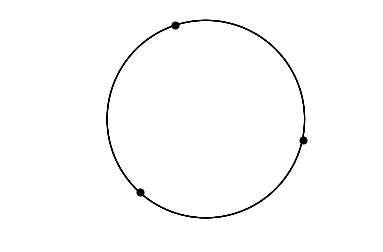

---------------------
Step No 0  ---> 146.1516875971766
Step No 1  ---> 148.54998020036382
Step No 2  ---> 154.85618486717507
Step No 3  ---> 154.18399511262848
Step No 4  ---> 145.31867314606217
Step No 5  ---> 156.2915972103874
Step No 6  ---> 153.61760491725303
Step No 7  ---> 149.19832114468588
Step No 8  ---> 147.89364112722075
Step No 9  ---> 159.37092847816064
Step No 10  ---> 169.14904247899662
Step No 11  ---> 171.496252640961
Step No 12  ---> 185.4995629128366
Step No 13  ---> 190.7207030675199
Step No 14  ---> 190.7207030675199
Step No 15  ---> 199.23796563286268
Step No 16  ---> 189.15189493425694
Step No 17  ---> 187.466626227834
Step No 18  ---> 188.91817360441902
Step No 19  ---> 195.53029377176964
Step No 20  ---> 196.0942103175456
Step No 21  ---> 202.79818535129272
Step No 22  ---> 201.19334073470839
Step No 23  ---> 204.4919590784106
Step No 24  ---> 208.9303798404327
Step No 25  ---> 209.6447418756906
Step No 26  ---> 195.51001202892377
Step No 27  ---> 190.94770929

Step No 178  ---> 19.60432817429341
Step No 179  ---> 19.60432817416073
Step No 180  ---> 19.60432817381193
Step No 181  ---> 19.604328173314105
Step No 182  ---> 19.604328173267188
Step No 183  ---> 19.604328173226154
Step No 184  ---> 19.604328173189092
Step No 185  ---> 19.604328173154848
Step No 186  ---> 19.60432817312269
Step No 187  ---> 19.60432817309222
Step No 188  ---> 19.604328173063106
Step No 189  ---> 19.604328173035242
Step No 190  ---> 19.604328173008415
Step No 191  ---> 19.604328172982658
Step No 192  ---> 19.604328172957803
Step No 193  ---> 19.604328172933858
Step No 194  ---> 19.60432817291084


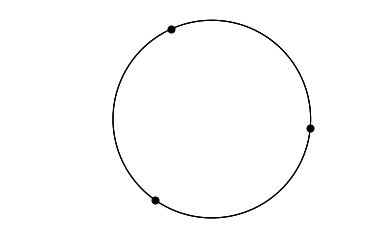

---------------------
Step No 0  ---> 88.96609108029007
Step No 1  ---> 89.34980024656774
Step No 2  ---> 92.67176490510225
Step No 3  ---> 98.42895729952882
Step No 4  ---> 100.73254500269914
Step No 5  ---> 108.39309192437136
Step No 6  ---> 105.56606884768235
Step No 7  ---> 114.9231655078499
Step No 8  ---> 124.17570575285092
Step No 9  ---> 124.94111159742005
Step No 10  ---> 121.28204631093413
Step No 11  ---> 119.37075665319847
Step No 12  ---> 128.55627767751582
Step No 13  ---> 137.13866267953517
Step No 14  ---> 137.4126781887494
Step No 15  ---> 145.1112647749486
Step No 16  ---> 142.16115174124474
Step No 17  ---> 147.02191272981437
Step No 18  ---> 139.98202060321753
Step No 19  ---> 139.98202060321753
Step No 20  ---> 146.59556931677457
Step No 21  ---> 144.49088098037092
Step No 22  ---> 147.58967815012548
Step No 23  ---> 153.71565997023532
Step No 24  ---> 160.20093870833514
Step No 25  ---> 157.0413723569888
Step No 26  ---> 156.54888165711668
Step No 27  ---> 162.522

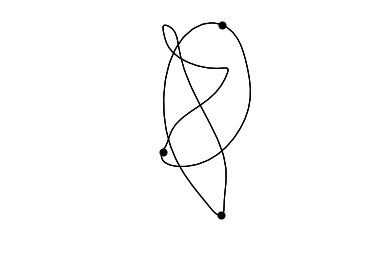

---------------------
Step No 0  ---> 73.19437042343607
Step No 1  ---> 74.06144507079745
Step No 2  ---> 75.11243369128157
Step No 3  ---> 75.11243369128157
Step No 4  ---> 78.49354256124462
Step No 5  ---> 81.37548561768837
Step No 6  ---> 90.40168184631656
Step No 7  ---> 89.9308476264678
Step No 8  ---> 88.25415201483645
Step No 9  ---> 88.84156240942434
Step No 10  ---> 94.00200649303324
Step No 11  ---> 92.41891949541744
Step No 12  ---> 92.70079069581232
Step No 13  ---> 97.13218159131627
Step No 14  ---> 104.8615552521459
Step No 15  ---> 104.86390137682996
Step No 16  ---> 103.79949153418286
Step No 17  ---> 106.41434588278723
Step No 18  ---> 103.4810066032295
Step No 19  ---> 104.4622778603745
Step No 20  ---> 109.8351246402633
Step No 21  ---> 104.76393448641265
Step No 22  ---> 113.67511315482062
Step No 23  ---> 113.31538693129775
Step No 24  ---> 111.62023285500483
Step No 25  ---> 121.30027164228166
Step No 26  ---> 126.63950110292865
Step No 27  ---> 124.93398641634296

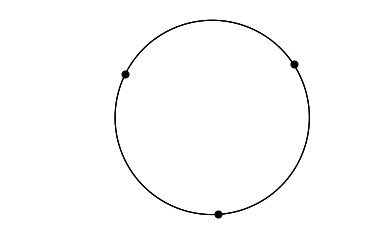

---------------------
Step No 0  ---> 104.93572672600685
Step No 1  ---> 105.40228770846234
Step No 2  ---> 105.70254322805987
Step No 3  ---> 107.43632414487615
Step No 4  ---> 118.17283492438914
Step No 5  ---> 107.1628027200866
Step No 6  ---> 102.36830048412361
Step No 7  ---> 109.33592841455581
Step No 8  ---> 106.7942744093319
Step No 9  ---> 111.44634195438701
Step No 10  ---> 114.52500338181446
Step No 11  ---> 111.81678949732522
Step No 12  ---> 110.1744944557039
Step No 13  ---> 118.20127091955369
Step No 14  ---> 130.3175881578727
Step No 15  ---> 128.96688117628042
Step No 16  ---> 123.93476520887076
Step No 17  ---> 123.93476520887076
Step No 18  ---> 124.44754628378304
Step No 19  ---> 124.44754628378304
Step No 20  ---> 114.89313332386058
Step No 21  ---> 117.11894374921889
Step No 22  ---> 122.45356497750929
Step No 23  ---> 123.52721498683931
Step No 24  ---> 119.91812786721249
Step No 25  ---> 120.7078854745686
Step No 26  ---> 120.9601817148917
Step No 27  ---> 130.7

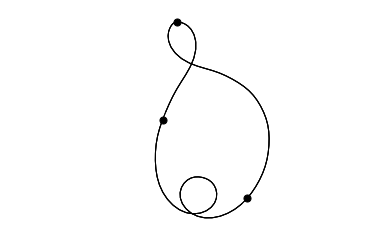

---------------------
Step No 0  ---> 105.22612090954867
Step No 1  ---> 108.30510867877203
Step No 2  ---> 113.56641442922972
Step No 3  ---> 109.81388575704388
Step No 4  ---> 116.14788365311104
Step No 5  ---> 122.19113206441851
Step No 6  ---> 134.12231464425102
Step No 7  ---> 143.15740731460056
Step No 8  ---> 142.4738084345105
Step No 9  ---> 153.02165086334932
Step No 10  ---> 153.46869922229757
Step No 11  ---> 153.46869922229757
Step No 12  ---> 153.08283974527313
Step No 13  ---> 149.23467394810984
Step No 14  ---> 149.23467394810984
Step No 15  ---> 148.35862109906336
Step No 16  ---> 162.33274572865696
Step No 17  ---> 157.72656536464262
Step No 18  ---> 163.34392559680802
Step No 19  ---> 158.577724725907
Step No 20  ---> 150.77802893043918
Step No 21  ---> 150.43470204218022
Step No 22  ---> 146.3517137676119
Step No 23  ---> 149.6260999729948
Step No 24  ---> 148.18171631026493
Step No 25  ---> 148.18171631026493
Step No 26  ---> 144.85550690181756
Step No 27  ---> 153.

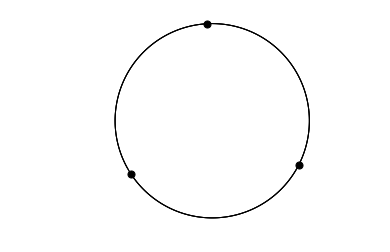

---------------------
Step No 0  ---> 102.84157052763909
Step No 1  ---> 100.64755813003391
Step No 2  ---> 102.20890538583984
Step No 3  ---> 97.46203746188861
Step No 4  ---> 105.573847679374
Step No 5  ---> 103.17249311870611
Step No 6  ---> 102.70993485792384
Step No 7  ---> 111.89818539632083
Step No 8  ---> 112.38399650992224
Step No 9  ---> 120.98488750364415
Step No 10  ---> 124.9754819762251
Step No 11  ---> 118.05133210049951
Step No 12  ---> 117.64881447523113
Step No 13  ---> 131.21372080300313
Step No 14  ---> 133.779147900997
Step No 15  ---> 129.68672101623326
Step No 16  ---> 139.3651219698323
Step No 17  ---> 140.77451831133635
Step No 18  ---> 153.7668246329443
Step No 19  ---> 153.7668246329443
Step No 20  ---> 167.0470060153623
Step No 21  ---> 152.97422289290478
Step No 22  ---> 152.98875133033718
Step No 23  ---> 153.71697937302355
Step No 24  ---> 158.16495663587497
Step No 25  ---> 159.3229369549617
Step No 26  ---> 159.37704647233966
Step No 27  ---> 156.322491

Step No 180  ---> 19.604328192440406
Step No 181  ---> 19.604328191018077
Step No 182  ---> 19.60432818865501
Step No 183  ---> 19.604328186839286
Step No 184  ---> 19.604328185747438
Step No 185  ---> 19.60432818521528
Step No 186  ---> 19.604328184749857
Step No 187  ---> 19.60432818433191
Step No 188  ---> 19.60432818394866
Step No 189  ---> 19.604328183591548
Step No 190  ---> 19.604328183254843
Step No 191  ---> 19.60432818303088
Step No 192  ---> 19.60432818244351
Step No 193  ---> 19.60432818063686
Step No 194  ---> 19.604328178269824
Step No 195  ---> 19.6043281780359
Step No 196  ---> 19.604328177835534
Step No 197  ---> 19.60432817765274
Step No 198  ---> 19.604328177483186
Step No 199  ---> 19.604328177323804
Step No 200  ---> 19.60432817717261
Step No 201  ---> 19.604328177062282
Step No 202  ---> 19.6043281768039
Step No 203  ---> 19.604328175796606
Step No 204  ---> 19.604328174893798
Step No 205  ---> 19.604328174776523
Step No 206  ---> 19.604328174689222
Step No 207  -

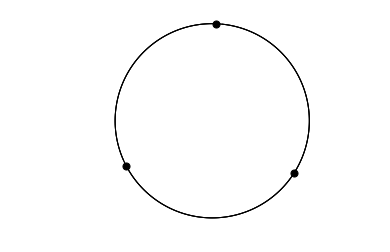

---------------------
Step No 0  ---> 97.85797375654681
Step No 1  ---> 105.19383661931094
Step No 2  ---> 102.61278818286765
Step No 3  ---> 98.65585014900225
Step No 4  ---> 97.32004872357345
Step No 5  ---> 98.48582327826334
Step No 6  ---> 98.48582327826334
Step No 7  ---> 99.39791270612328
Step No 8  ---> 99.38833116046467
Step No 9  ---> 107.71675511531133
Step No 10  ---> 110.10578275353828
Step No 11  ---> 113.39528626321086
Step No 12  ---> 117.88975163186824
Step No 13  ---> 118.6019002528915
Step No 14  ---> 122.65714476210292
Step No 15  ---> 126.7531202023395
Step No 16  ---> 131.76890260201264
Step No 17  ---> 134.79452199602832
Step No 18  ---> 133.04740417194049
Step No 19  ---> 133.46446908619598
Step No 20  ---> 136.55214131756213
Step No 21  ---> 136.17212311041274
Step No 22  ---> 131.81203554668602
Step No 23  ---> 135.95258668969643
Step No 24  ---> 134.77295310275986
Step No 25  ---> 134.77295310275986
Step No 26  ---> 144.6463065085624
Step No 27  ---> 142.88596

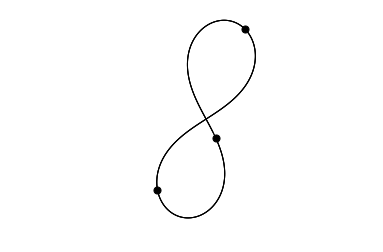

---------------------
Step No 0  ---> 137.00328399611092
Step No 1  ---> 140.62006085104844
Step No 2  ---> 140.49938857186203
Step No 3  ---> 136.44440188173047
Step No 4  ---> 146.50572218598137
Step No 5  ---> 150.8158914408151
Step No 6  ---> 155.87487473438114
Step No 7  ---> 159.07807861776803
Step No 8  ---> 165.1534357560114
Step No 9  ---> 165.84243488748436
Step No 10  ---> 162.2188544126966
Step No 11  ---> 162.74864005301524
Step No 12  ---> 165.3519787973288
Step No 13  ---> 167.84996171388192
Step No 14  ---> 174.29210773402264
Step No 15  ---> 172.24127040702928
Step No 16  ---> 177.67582916999984
Step No 17  ---> 177.67582916999984
Step No 18  ---> 179.61473847625402
Step No 19  ---> 178.27999834106643
Step No 20  ---> 177.1736916246716
Step No 21  ---> 175.85389845224205
Step No 22  ---> 173.04231814084145
Step No 23  ---> 173.79753772646336
Step No 24  ---> 168.00625986355814
Step No 25  ---> 160.97165402296565
Step No 26  ---> 158.19920589241977
Step No 27  ---> 158.

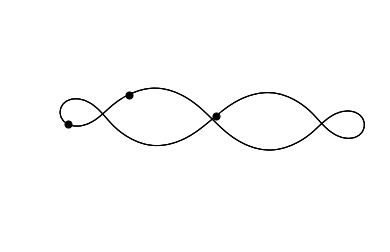

---------------------
Step No 0  ---> 84.25265274841233
Step No 1  ---> 85.80447293656549
Step No 2  ---> 87.8919493714508
Step No 3  ---> 88.72195090046287
Step No 4  ---> 85.06370213718736
Step No 5  ---> 80.4283638439733
Step No 6  ---> 80.04152823564011
Step No 7  ---> 80.61569986024136
Step No 8  ---> 86.52025117765442
Step No 9  ---> 86.52025117765442
Step No 10  ---> 91.79803540455428
Step No 11  ---> 96.21363885279023
Step No 12  ---> 96.21363885279023
Step No 13  ---> 98.17548716550974
Step No 14  ---> 101.17689466465457
Step No 15  ---> 102.91979769515247
Step No 16  ---> 103.86058093625175
Step No 17  ---> 107.42262932543579
Step No 18  ---> 109.36917747985473
Step No 19  ---> 112.83496267772563
Step No 20  ---> 112.83496267772563
Step No 21  ---> 117.55727057556997
Step No 22  ---> 122.62525885938445
Step No 23  ---> 108.73385131498483
Step No 24  ---> 116.79075440624686
Step No 25  ---> 112.37980194182133
Step No 26  ---> 114.52109272141082
Step No 27  ---> 115.01788850799

Step No 179  ---> 19.604328307189284
Step No 180  ---> 19.604328238472963
Step No 181  ---> 19.60432821327316
Step No 182  ---> 19.604328211145006
Step No 183  ---> 19.604328208280133
Step No 184  ---> 19.604328199056066
Step No 185  ---> 19.604328193687838
Step No 186  ---> 19.604328192110398
Step No 187  ---> 19.60432819107465
Step No 188  ---> 19.60432818730205
Step No 189  ---> 19.60432818344542
Step No 190  ---> 19.60432818303699
Step No 191  ---> 19.604328182630557
Step No 192  ---> 19.604328182290736
Step No 193  ---> 19.604328181983902
Step No 194  ---> 19.604328181697138
Step No 195  ---> 19.604328181424822
Step No 196  ---> 19.604328181238145
Step No 197  ---> 19.604328180750485
Step No 198  ---> 19.60432817869189
Step No 199  ---> 19.604328177252906
Step No 200  ---> 19.604328177077356
Step No 201  ---> 19.604328176623234
Step No 202  ---> 19.60432817629466
Step No 203  ---> 19.60432817610536
Step No 204  ---> 19.604328175960188
Step No 205  ---> 19.604328175835207
Step No 2

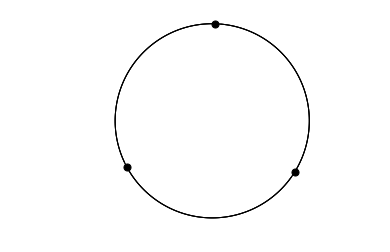

---------------------
Step No 0  ---> 137.51992108243297
Step No 1  ---> 143.77736676277408
Step No 2  ---> 149.18584850265518
Step No 3  ---> 157.71808525818534
Step No 4  ---> 157.71808525818534
Step No 5  ---> 165.2356405350592
Step No 6  ---> 157.75876646875128
Step No 7  ---> 162.49256239865568
Step No 8  ---> 162.49256239865568
Step No 9  ---> 155.24324602154988
Step No 10  ---> 157.94038977215396
Step No 11  ---> 162.7042919590341
Step No 12  ---> 164.78834694004732
Step No 13  ---> 164.21949690739115
Step No 14  ---> 163.89028955386758
Step No 15  ---> 161.90979155196953
Step No 16  ---> 170.67934423961398
Step No 17  ---> 177.55371327408275
Step No 18  ---> 182.4089296156126
Step No 19  ---> 180.38486059430437
Step No 20  ---> 189.76293067332523
Step No 21  ---> 195.17446974891297
Step No 22  ---> 201.88832013436033
Step No 23  ---> 197.14090087829888
Step No 24  ---> 199.00292041569054
Step No 25  ---> 199.00292041569054
Step No 26  ---> 196.6732322626865
Step No 27  ---> 199

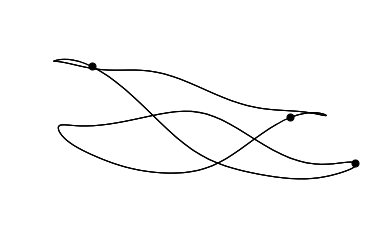

---------------------
Step No 0  ---> 74.33337851564632
Step No 1  ---> 78.4392259000017
Step No 2  ---> 81.34508166010542
Step No 3  ---> 84.04025218352089
Step No 4  ---> 87.83830292123118
Step No 5  ---> 90.42331792122563
Step No 6  ---> 95.20090369317636
Step No 7  ---> 96.72971930675608
Step No 8  ---> 101.3848787506826
Step No 9  ---> 106.19538827885361
Step No 10  ---> 107.0044734223884
Step No 11  ---> 106.73168797884583
Step No 12  ---> 111.02477388659325
Step No 13  ---> 108.7778303189882
Step No 14  ---> 113.71587526192977
Step No 15  ---> 110.495796335273
Step No 16  ---> 112.86848228977246
Step No 17  ---> 115.75144678431622
Step No 18  ---> 115.9857122683352
Step No 19  ---> 125.42372447843391
Step No 20  ---> 123.92589974357034
Step No 21  ---> 122.60065063401612
Step No 22  ---> 122.60065063401612
Step No 23  ---> 124.59789244822241
Step No 24  ---> 141.4419679939327
Step No 25  ---> 146.74605896366236
Step No 26  ---> 140.48772761108015
Step No 27  ---> 143.48883432628

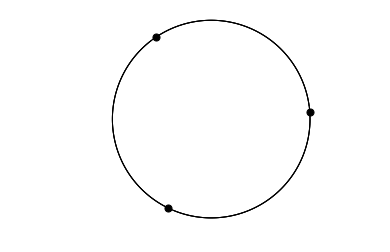

---------------------
Step No 0  ---> 124.44138030514165
Step No 1  ---> 116.74803654700666
Step No 2  ---> 118.75651668281286
Step No 3  ---> 121.8478435764435
Step No 4  ---> 131.86659221490356
Step No 5  ---> 132.51105807027253
Step No 6  ---> 140.9248744212423
Step No 7  ---> 141.41355102362084
Step No 8  ---> 136.55245891556967
Step No 9  ---> 136.46921653199132
Step No 10  ---> 143.15947659047566
Step No 11  ---> 135.68284375464643
Step No 12  ---> 143.4732900647378
Step No 13  ---> 137.8181489658017
Step No 14  ---> 140.0046425015934
Step No 15  ---> 144.76488234649668
Step No 16  ---> 151.82122235988027
Step No 17  ---> 149.91196748240182
Step No 18  ---> 144.23334478399795
Step No 19  ---> 152.6051580277122
Step No 20  ---> 149.8281265875038
Step No 21  ---> 151.24878145007114
Step No 22  ---> 141.27003362523266
Step No 23  ---> 143.08527194818592
Step No 24  ---> 143.06006736705407
Step No 25  ---> 142.74524952055262
Step No 26  ---> 142.74524952055262
Step No 27  ---> 153.26

Step No 185  ---> 19.60432817352508
Step No 186  ---> 19.604328173215826
Step No 187  ---> 19.60432817293316
Step No 188  ---> 19.60432817289706
Step No 189  ---> 19.60432817286983
Step No 190  ---> 19.604328172844788
Step No 191  ---> 19.60432817282137
Step No 192  ---> 19.604328172799228


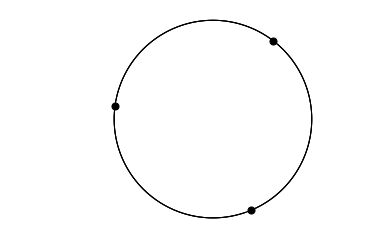

---------------------
Step No 0  ---> 56.890708990734424
Step No 1  ---> 62.503386696434845
Step No 2  ---> 67.32056413243545
Step No 3  ---> 70.23754703763497
Step No 4  ---> 66.96995874369335
Step No 5  ---> 74.3393161227619
Step No 6  ---> 81.18361956542748
Step No 7  ---> 85.70087430847545
Step No 8  ---> 90.81668775007839
Step No 9  ---> 89.56779787678802
Step No 10  ---> 89.6020249907748
Step No 11  ---> 87.76991006511467
Step No 12  ---> 87.66366353307018
Step No 13  ---> 88.014383041147
Step No 14  ---> 94.86012354882608
Step No 15  ---> 93.86145208366258
Step No 16  ---> 94.83072420038721
Step No 17  ---> 101.26592261328254
Step No 18  ---> 95.94227525546717
Step No 19  ---> 102.47621166060178
Step No 20  ---> 105.6703973406411
Step No 21  ---> 113.28616636660465
Step No 22  ---> 113.28616636660465
Step No 23  ---> 115.17272304629586
Step No 24  ---> 109.39709047346584
Step No 25  ---> 111.69436636503137
Step No 26  ---> 118.47745995863983
Step No 27  ---> 130.91485291989375
S

Step No 187  ---> 19.604328173840557
Step No 188  ---> 19.604328173748335
Step No 189  ---> 19.60432817337566
Step No 190  ---> 19.60432817306648
Step No 191  ---> 19.604328173023806
Step No 192  ---> 19.604328172993
Step No 193  ---> 19.60432817296448
Step No 194  ---> 19.604328172937702
Step No 195  ---> 19.604328172912336
Step No 196  ---> 19.604328172888135
Step No 197  ---> 19.604328172872126


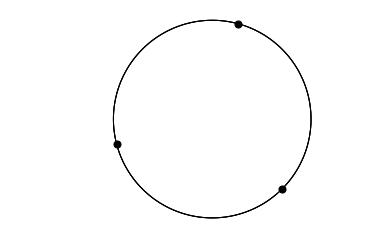

---------------------
Step No 0  ---> 106.91230406123717
Step No 1  ---> 112.14967333862823
Step No 2  ---> 109.93185389323575
Step No 3  ---> 112.78264440645715
Step No 4  ---> 111.75690735228352
Step No 5  ---> 117.49212341955098
Step No 6  ---> 122.37705985568464
Step No 7  ---> 123.0291365626584
Step No 8  ---> 124.45055858144164
Step No 9  ---> 132.7460840219926
Step No 10  ---> 137.91230013469576
Step No 11  ---> 137.91230013469576
Step No 12  ---> 132.19966119104646
Step No 13  ---> 143.50430113470455
Step No 14  ---> 129.88525940781147
Step No 15  ---> 135.92936118007063
Step No 16  ---> 131.29973071542838
Step No 17  ---> 137.43342377029524
Step No 18  ---> 135.15029524735218
Step No 19  ---> 139.48209260908166
Step No 20  ---> 133.12635029322396
Step No 21  ---> 136.08001629264803
Step No 22  ---> 138.43011182813837
Step No 23  ---> 140.85144095888882
Step No 24  ---> 140.2911933676069
Step No 25  ---> 146.78697299499427
Step No 26  ---> 145.16037015586988
Step No 27  ---> 14

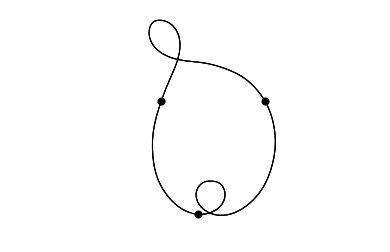

---------------------
Step No 0  ---> 147.01617629178992
Step No 1  ---> 153.45986296959663
Step No 2  ---> 158.00224016382484
Step No 3  ---> 163.497038028909
Step No 4  ---> 165.15610929282613
Step No 5  ---> 171.33474845282365
Step No 6  ---> 177.33740196922992
Step No 7  ---> 173.74775079749386
Step No 8  ---> 182.0686096141156
Step No 9  ---> 182.60005076481008
Step No 10  ---> 186.74492272167393
Step No 11  ---> 186.86569322298345
Step No 12  ---> 182.4615625388793
Step No 13  ---> 188.24614714597078
Step No 14  ---> 194.47438414666817
Step No 15  ---> 190.18491854300675
Step No 16  ---> 196.66565466886672
Step No 17  ---> 218.5346660056817
Step No 18  ---> 215.61260287415183
Step No 19  ---> 217.14079200522303
Step No 20  ---> 214.39154398692887
Step No 21  ---> 214.39154398692887
Step No 22  ---> 215.40293706739436
Step No 23  ---> 215.4798964357823
Step No 24  ---> 211.62497603630612
Step No 25  ---> 202.13269657613162
Step No 26  ---> 204.2401981495857
Step No 27  ---> 212.69

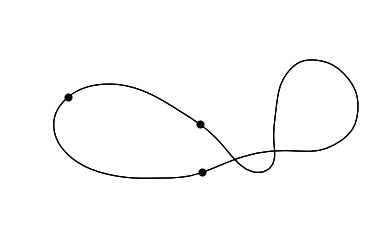

---------------------
Step No 0  ---> 122.23457535725196
Step No 1  ---> 125.26118778176605
Step No 2  ---> 134.95383939862188
Step No 3  ---> 138.70209832110305
Step No 4  ---> 141.49969581675074
Step No 5  ---> 149.16902211061287
Step No 6  ---> 151.15925115911662
Step No 7  ---> 150.92806946815102
Step No 8  ---> 155.98717440470958
Step No 9  ---> 160.94112898263572
Step No 10  ---> 160.22992969711228
Step No 11  ---> 166.2225768727346
Step No 12  ---> 168.05042311649527
Step No 13  ---> 175.1591198484249
Step No 14  ---> 175.1591198484249
Step No 15  ---> 174.40788628544374
Step No 16  ---> 174.88550675648005
Step No 17  ---> 180.50445565858394
Step No 18  ---> 183.7939708850949
Step No 19  ---> 185.1695460945989
Step No 20  ---> 183.2249581416662
Step No 21  ---> 180.6200910484612
Step No 22  ---> 179.62550421160566
Step No 23  ---> 184.77364796146094
Step No 24  ---> 190.42795362575828
Step No 25  ---> 195.70524275404222
Step No 26  ---> 187.6543105849355
Step No 27  ---> 194.634

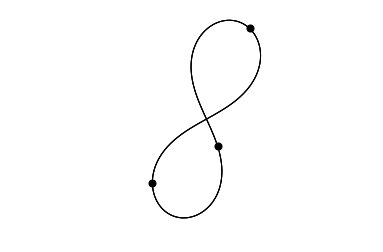

---------------------
Step No 0  ---> 132.89388144201567
Step No 1  ---> 133.85304160927026
Step No 2  ---> 138.8555737103347
Step No 3  ---> 143.68851420129073
Step No 4  ---> 145.81419946388544
Step No 5  ---> 153.6827284837915
Step No 6  ---> 162.23833273101337
Step No 7  ---> 167.16163832153705
Step No 8  ---> 161.10421947588458
Step No 9  ---> 165.5788039963373
Step No 10  ---> 170.69624796305348
Step No 11  ---> 168.10251247727507
Step No 12  ---> 173.3743140702907
Step No 13  ---> 160.66229180728413
Step No 14  ---> 161.4876567705181
Step No 15  ---> 169.20020763537016
Step No 16  ---> 168.48445449798774
Step No 17  ---> 169.456932443366
Step No 18  ---> 171.58641592647146
Step No 19  ---> 167.39802659551535
Step No 20  ---> 163.6727452778792
Step No 21  ---> 170.54467968452843
Step No 22  ---> 171.81753282539043
Step No 23  ---> 180.9065700219463
Step No 24  ---> 178.43109510636742
Step No 25  ---> 174.114956039342
Step No 26  ---> 171.69630380559482
Step No 27  ---> 172.562823

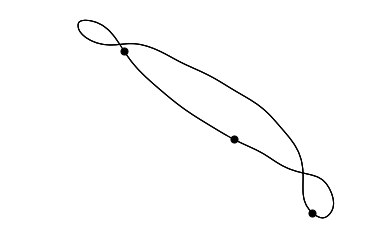

---------------------
Step No 0  ---> 109.77476205983743
Step No 1  ---> 109.75735104519624
Step No 2  ---> 111.5859932681122
Step No 3  ---> 118.74136401960915
Step No 4  ---> 119.91396454542276
Step No 5  ---> 124.85748507801407
Step No 6  ---> 129.53006969971327
Step No 7  ---> 141.00003253335316
Step No 8  ---> 147.98463598048642
Step No 9  ---> 142.7913519440348
Step No 10  ---> 148.80251774641602
Step No 11  ---> 149.41225730368257
Step No 12  ---> 156.59607910517516
Step No 13  ---> 141.24510558383682
Step No 14  ---> 151.22482901830173
Step No 15  ---> 147.97139431209823
Step No 16  ---> 151.02663596489805
Step No 17  ---> 146.23446735978376
Step No 18  ---> 146.23446735978376
Step No 19  ---> 150.84815102531897
Step No 20  ---> 144.53203848845297
Step No 21  ---> 145.00798543259413
Step No 22  ---> 150.96260900554466
Step No 23  ---> 151.52526808869982
Step No 24  ---> 156.87129426618554
Step No 25  ---> 153.98857289887644
Step No 26  ---> 151.94251526001892
Step No 27  ---> 1

Step No 180  ---> 38.69302335675048
Step No 181  ---> 38.6930233367516
Step No 182  ---> 38.693023321009896
Step No 183  ---> 38.693023296846015
Step No 184  ---> 38.69302327846927
Step No 185  ---> 38.69302326258398
Step No 186  ---> 38.69302324785093
Step No 187  ---> 38.693023233727565
Step No 188  ---> 38.69302322000457
Step No 189  ---> 38.69302320660579
Step No 190  ---> 38.69302319351799
Step No 191  ---> 38.69302318075063
Step No 192  ---> 38.69302316833226
Step No 193  ---> 38.693023156296476
Step No 194  ---> 38.69302313629859
Step No 195  ---> 38.693022739674284
Step No 196  ---> 38.69302235202882
Step No 197  ---> 38.69302234087987
Step No 198  ---> 38.69302233364994
Step No 199  ---> 38.69302232200314
Step No 200  ---> 38.69302211810126
Step No 201  ---> 38.693021886091636
Step No 202  ---> 38.69302187380025
Step No 203  ---> 38.69302186655362
Step No 204  ---> 38.693021860318495
Step No 205  ---> 38.69302185188949
Step No 206  ---> 38.693021789789135
Step No 207  ---> 38.

In [ ]:
mypath = "/Users/facundosapienza/Dropbox/Compartido/TP Final Optimización/Orbitas - Minimización sin restricciónes"
#mypath = "/home/facu/Dropbox/Compartido/TP Final Optimización/Orbitas - Minimización sin restricciónes"
NUMBER_EXPERIMENTS = 100

for ii in range(NUMBER_EXPERIMENTS):

    print("---------------------")
    
    """
    Normal gradient descent with fixed learning rate
    """
    #W = gradient_descent_0(LEARNING_RATE=1e-2, LEARNING_STEPS, ploteo=True)

    """
    Gradient descent with Armijo's Rule
    """
    #W = armijo(LEARNING_STEPS, eps=0.2)

    """
    Simulated annealing
    """
    #W = simulated_annealing(LEARNING_STEPS=200)
    
    """
    Mixture of models
    """
    W = mixture(LEARNING_STEPS_INIT=50, LEARNING_STEPS_ARMIJO=500)
    
    plt.close()
    ploteo_trayectorias(W, show=False)
    plt.show()
    
    #plt.savefig( "Coreo_Mixture_2-"+ str(ii) + "_orbitas.png", format="png", dpi=300)